# CLICKED VS SHOWED INTERACTIONS

## Simple comparison between the pairs (user, item) that have had interaction 0 (showed) versus interaction 1 (clicked) during last week

This notebook tries to get insights into why users delete job notifications and why they click on job offers:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [2]:
# Import interactions last week
folderData = 'data/'
interactions = pd.read_pickle(folderData + 'interactionsDataLastWeek.pkl')
interactions.head()

,user_id,item_id,interaction_type,created_at,created_at_date
1,1934123,140,1,1486388563,2017-02-06 13:42:43
4,1635596,310,1,1486370081,2017-02-06 08:34:41
40,1341483,680,1,1486104601,2017-02-03 06:50:01
45,2335852,680,1,1486377314,2017-02-06 10:35:14
48,287404,680,2,1486079907,2017-02-02 23:58:27


In [6]:
# Select the interactions of type showed
showed_interactions = interactions[interactions.interaction_type==0]
showed_interactions.reset_index(inplace=True, drop=True)
showed_interactions.head()

,user_id,item_id,interaction_type,created_at,created_at_date
0,1987803,310,0,1486021700,2017-02-02 07:48:20
1,1392038,310,0,1486035076,2017-02-02 11:31:16
2,654311,890,0,1486102408,2017-02-03 06:13:28
3,654311,890,0,1486102435,2017-02-03 06:13:55
4,496972,890,0,1486023859,2017-02-02 08:24:19


In [8]:
# Select the interactions of type clicked
clicked_interactions = interactions[interactions.interaction_type==1]
clicked_interactions.reset_index(inplace=True, drop=True)
clicked_interactions.head()

,user_id,item_id,interaction_type,created_at,created_at_date
0,1934123,140,1,1486388563,2017-02-06 13:42:43
1,1635596,310,1,1486370081,2017-02-06 08:34:41
2,1341483,680,1,1486104601,2017-02-03 06:50:01
3,2335852,680,1,1486377314,2017-02-06 10:35:14
4,287404,680,1,1485911258,2017-02-01 01:07:38


Do we have (user, item) pairs that are common between both groups?

In [9]:
intersection = pd.merge(showed_interactions, clicked_interactions, how='inner', on=['user_id', 'item_id'])

In [10]:
intersection.head()

,user_id,item_id,interaction_type_x,created_at_x,created_at_date_x,interaction_type_y,created_at_y,created_at_date_y
0,1560234,765141,0,1486026062,2017-02-02 09:01:02,1,1486072257,2017-02-02 21:50:57
1,1631970,942012,0,1486076194,2017-02-02 22:56:34,1,1486109253,2017-02-03 08:07:33
2,1631970,942012,0,1486076108,2017-02-02 22:55:08,1,1486109253,2017-02-03 08:07:33
3,1223390,153313,0,1486238232,2017-02-04 19:57:12,1,1486037910,2017-02-02 12:18:30
4,1223390,153313,0,1486025844,2017-02-02 08:57:24,1,1486037910,2017-02-02 12:18:30


Drop the intersections from showed_interactions and clicked_interactions

In [11]:
idx = showed_interactions['user_id'].isin(intersection['user_id']) & showed_interactions['item_id'].isin(intersection['item_id'])
showed_interactions = showed_interactions[~idx]

In [12]:
idx = clicked_interactions['user_id'].isin(intersection['user_id']) & clicked_interactions['item_id'].isin(intersection['item_id'])
clicked_interactions = clicked_interactions[~idx]

From the intersections, let's check which interaction was last, in order to add it again to the corresponding variable. We assume that someone who first deletes and then clicks, is like clicking, and if someone first clicks and then deletes, is like deleting.

In [13]:
idx = intersection[['created_at_x', 'created_at_y']].max(axis=1)==intersection.created_at_x
idx.value_counts()

True     13
False    13
dtype: int64

In [14]:
aux = intersection.loc[idx, ['user_id', 'item_id', 'interaction_type_x','created_at_x']]
aux.columns = ['user_id', 'item_id', 'interaction_type','created_at']
showed_interactions = pd.concat([showed_interactions, aux], ignore_index=True)

In [15]:
aux = intersection.loc[~idx, ['user_id', 'item_id', 'interaction_type_y','created_at_y']]
aux.columns = ['user_id', 'item_id', 'interaction_type','created_at']
clicked_interactions = pd.concat([clicked_interactions, aux], ignore_index=True)

Import all users and items data

In [16]:
# Import all users
users = pd.read_csv(folderData + 'users.csv', sep='\t')
users.columns = ['user_id', 'jobroles', 'career_level', 'discipline_id', 'industry_id', 'country', 'region',
                'experience_n_entries_class', 'experience_years_experience', 'experience_years_in_current',
                'edu_degree', 'edu_fieldofstudies', 'wtcj', 'premium']

In [17]:
# Fill empties and transform the strings into a list
users.jobroles = users.jobroles.fillna('0').apply(lambda str: set(str.split(',')))
users.edu_fieldofstudies = users.edu_fieldofstudies.fillna('0').apply(lambda str: set(str.split(',')))

In [18]:
# Import all items
items = pd.read_csv(folderData + 'items.csv', sep='\t')
items.columns = ['item_id', 'title', 'career_level', 'discipline_id', 'industry_id', 'country', 'is_payed', 'region',
                'latitude', 'longitude', 'employment', 'tags', 'created_at']

In [19]:
# Fill empties and transform the strings into a list
items.title = items.title.fillna('0').apply(lambda str: set(str.split(',')))
items.tags = items.tags.fillna('0').apply(lambda str: set(str.split(',')))
items['created_at_dt'] = pd.to_datetime(items.created_at,unit='s', errors='coerce')

In [20]:
# Merge data sets. Find all the information of users and items that have an interaction of type 4
data_showed = showed_interactions.merge(users, on='user_id', how='inner')
data_showed = data_showed.merge(items, on='item_id', how='inner', suffixes=('_user', '_item'))
data_showed.head()

,created_at_user,created_at_date,interaction_type,item_id,user_id,jobroles,career_level_user,discipline_id_user,industry_id_user,country_user,...,industry_id_item,country_item,is_payed,region_item,latitude,longitude,employment,tags,created_at_item,created_at_dt
0,1486021700,2017-02-02 07:48:20,0,310,1987803,"{1589722, 2087584}",0,0,8,at,...,9,at,0,0,47.1,15.5,1,"{3989138, 2379175, 3671787, 1175363, 49361, 35...",1483138800,2016-12-30 23:00:00
1,1486035076,2017-02-02 11:31:16,0,310,1392038,"{427470, 2994300}",3,0,16,at,...,9,at,0,0,47.1,15.5,1,"{3989138, 2379175, 3671787, 1175363, 49361, 35...",1483138800,2016-12-30 23:00:00
2,1486021916,2017-02-02 07:51:56,0,349770,1987803,"{1589722, 2087584}",0,0,8,at,...,23,de,1,9,51.2,6.8,1,"{1935579, 202201, 3606563, 2854608, 647898, 21...",1481670000,2016-12-13 23:00:00
3,1486053835,2017-02-02 16:43:55,0,349770,556000,"{665762, 1464528, 2994300, 4302676, 3544650, 3...",6,23,15,de,...,23,de,1,9,51.2,6.8,1,"{1935579, 202201, 3606563, 2854608, 647898, 21...",1481670000,2016-12-13 23:00:00
4,1486117303,2017-02-03 10:21:43,0,349770,405314,{582235},4,16,16,de,...,23,de,1,9,51.2,6.8,1,"{1935579, 202201, 3606563, 2854608, 647898, 21...",1481670000,2016-12-13 23:00:00


In [21]:
# Remove interaction type
data_showed.drop(['interaction_type'], axis=1, inplace=True)
data_showed.shape

(840559, 30)

In [22]:
# Merge data sets. Find all the information of users and items that have an interaction of type 3
data_clicked = clicked_interactions.merge(users, on='user_id', how='inner')
data_clicked = data_clicked.merge(items, on='item_id', how='inner', suffixes=('_user', '_item'))
data_clicked.head()

,created_at_user,created_at_date,interaction_type,item_id,user_id,jobroles,career_level_user,discipline_id_user,industry_id_user,country_user,...,industry_id_item,country_item,is_payed,region_item,latitude,longitude,employment,tags,created_at_item,created_at_dt
0,1486388563,2017-02-06 13:42:43,1,140,1934123,"{2712747, 981567, 1663083, 821921, 1208672, 27...",3,22,10,ch,...,17,ch,0,0,46.9,7.4,1,"{1627300, 540282, 3418248}",1479942000,2016-11-23 23:00:00
1,1486388533,2017-02-06 13:42:13,1,360820,1934123,"{2712747, 981567, 1663083, 821921, 1208672, 27...",3,22,10,ch,...,7,ch,0,0,46.9,7.4,1,"{1868189, 3858649, 1760579, 4313058, 3502994, ...",1484262000,2017-01-12 23:00:00
2,1486371745,2017-02-06 09:02:25,1,466480,1934123,"{2712747, 981567, 1663083, 821921, 1208672, 27...",3,22,10,ch,...,16,ch,0,0,47.4,7.9,3,{0},1481929200,2016-12-16 23:00:00
3,1486365219,2017-02-06 07:13:39,1,466480,1934123,"{2712747, 981567, 1663083, 821921, 1208672, 27...",3,22,10,ch,...,16,ch,0,0,47.4,7.9,3,{0},1481929200,2016-12-16 23:00:00
4,1486331551,2017-02-05 21:52:31,1,466480,1428523,"{2873190, 2070276}",3,0,16,ch,...,16,ch,0,0,47.4,7.9,3,{0},1481929200,2016-12-16 23:00:00


In [23]:
# Remove interaction type
data_clicked.drop(['interaction_type'], axis=1, inplace=True)
data_clicked.shape

(503441, 30)

In [24]:
print data_clicked.columns

Index([u'created_at_user', u'created_at_date', u'item_id', u'user_id',
       u'jobroles', u'career_level_user', u'discipline_id_user',
       u'industry_id_user', u'country_user', u'region_user',
       u'experience_n_entries_class', u'experience_years_experience',
       u'experience_years_in_current', u'edu_degree', u'edu_fieldofstudies',
       u'wtcj', u'premium', u'title', u'career_level_item',
       u'discipline_id_item', u'industry_id_item', u'country_item',
       u'is_payed', u'region_item', u'latitude', u'longitude', u'employment',
       u'tags', u'created_at_item', u'created_at_dt'],
      dtype='object')


In [25]:
# Select all users and items who have been involved with interaction 0
idx = users.user_id.isin(data_showed.user_id)
users_not_interested = users.ix[idx].reset_index(drop=True)
idx = items.item_id.isin(data_showed.item_id)
items_not_interesting = items.ix[idx].reset_index(drop=True)

In [26]:
# Select all users and items who have been involved with interaction 1
idx = users.user_id.isin(data_clicked.user_id)
users_interested = users.ix[idx].reset_index(drop=True)
idx = items.item_id.isin(data_clicked.item_id)
items_interesting = items.ix[idx].reset_index(drop=True)

# Let's study each one of the columns and compare the values between both groups to see if there are differences

## Career level

Which career level do users have? Does it match the career level asked at the job?

In [27]:
data_showed.career_level_user.value_counts().sort_index().to_dict()

{0: 259712, 1: 7627, 2: 34384, 3: 272501, 4: 161513, 5: 43079, 6: 61743}

In [28]:
data_showed.career_level_item.value_counts().sort_index().to_dict()

{1: 1949, 2: 22686, 3: 444571, 4: 292592, 5: 58365, 6: 20396}

In [29]:
data_clicked.career_level_user.value_counts().sort_index().to_dict()

{0: 164006, 1: 5468, 2: 22843, 3: 182760, 4: 85673, 5: 21210, 6: 21481}

In [30]:
data_clicked.career_level_item.value_counts().sort_index().to_dict()

{1: 13161, 2: 21077, 3: 331991, 4: 104723, 5: 26249, 6: 6240}

Lets only look at the data for which we know the career level (ignore case 0)

In [31]:
subset1 = data_showed[data_showed.career_level_user!=0]
n = float(len(subset1))
print np.sum(subset1.career_level_item==subset1.career_level_user)/n*100.0
print np.sum(subset1.career_level_item>subset1.career_level_user)/n*100.0
print np.sum(subset1.career_level_item<subset1.career_level_user)/n*100.0

51.0979655572
23.820558598
25.0814758448


In [32]:
diff_career_level = subset1.career_level_user-subset1.career_level_item
diff_career_level.value_counts().sort_index().to_dict()

{-5: 13,
 -4: 196,
 -3: 2523,
 -2: 21949,
 -1: 113680,
 0: 296801,
 1: 95539,
 2: 34316,
 3: 15829,
 4: 1}

Approximately 51% of interactions of type 0 have the same career level

In [33]:
subset2 = data_clicked[data_clicked.career_level_user!=0]
n = float(len(subset2))
print np.sum(subset2.career_level_item==subset2.career_level_user)/n*100.0
print np.sum(subset2.career_level_item>subset2.career_level_user)/n*100.0
print np.sum(subset2.career_level_item<subset2.career_level_user)/n*100.0

53.4773962614
20.319354221
26.2032495176


In [34]:
diff_career_level = subset2.career_level_user-subset2.career_level_item
diff_career_level.value_counts().sort_index().to_dict()

{-5: 5,
 -4: 59,
 -3: 1065,
 -2: 9432,
 -1: 58410,
 0: 181521,
 1: 58918,
 2: 17435,
 3: 11392,
 4: 778,
 5: 420}

Not much differece in both groups

Conclusion:

    1. In both showed and clicked interactions, the career level match behaves similarly, however it seems that for click it is a bit more important.


## Discipline id

Let's ask the same questions

In [35]:
data_showed.discipline_id_user.value_counts().head()

0     559004
4      59119
5      45715
17     39466
16     23890
Name: discipline_id_user, dtype: int64

In [36]:
data_showed.discipline_id_item.value_counts().head()

5     134492
16    106507
17    106360
21     88435
4      69444
Name: discipline_id_item, dtype: int64

In [37]:
# Remove the unknowns which are labelled as 0 and compute percentages
subset1 = data_showed[data_showed.discipline_id_user!=0]
n = float(len(subset1))
print np.sum(subset1.discipline_id_item==subset1.discipline_id_user)/n*100.0

53.225479924


In [38]:
# Remove the unknowns which are labelled as 0 and compute percentages
subset2 = data_clicked[data_clicked.discipline_id_user!=0]
n = float(len(subset2))
print np.sum(subset2.discipline_id_item==subset2.discipline_id_user)/n*100.0

45.3345397754


Having a discpline match when showing a job seems more important than when clicking

Are particular disciplines more popular or less popular?

    1. Users

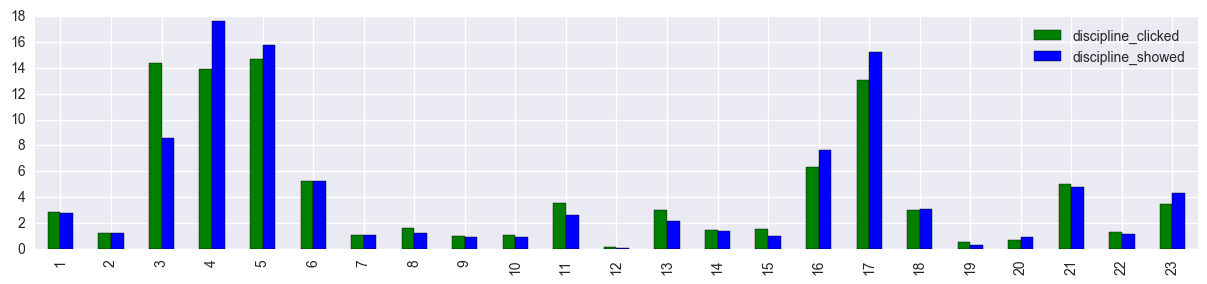

In [40]:
discipline_showed = users_not_interested[users_not_interested.discipline_id!=0].discipline_id.value_counts()/len(users_not_interested[users_not_interested.discipline_id!=0])*100
discipline_clicked = users_interested[users_interested.discipline_id!=0].discipline_id.value_counts()/len(users_interested[users_interested.discipline_id!=0])*100
df = pd.DataFrame({'discipline_showed':discipline_showed, 'discipline_clicked':discipline_clicked})
df.plot(kind='bar', figsize=(15, 3), color=['green', 'blue']);

    2. items

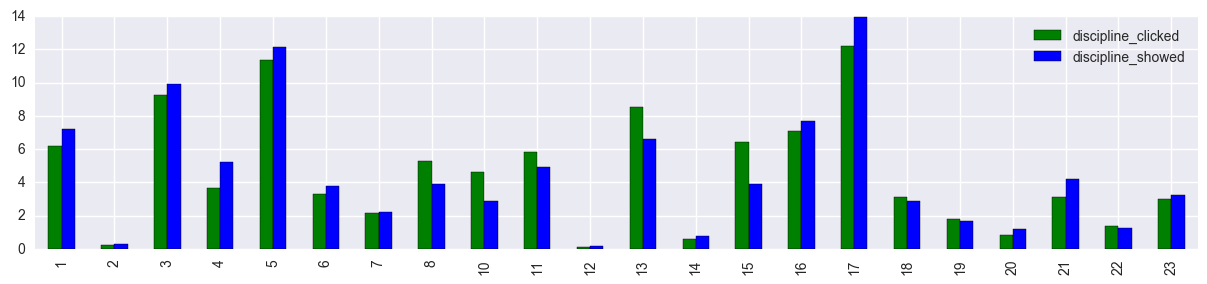

In [41]:
discipline_showed = items_not_interesting[items_not_interesting.discipline_id!=0].discipline_id.value_counts()/len(items_not_interesting[items_not_interesting.discipline_id!=0])*100
discipline_clicked = items_interesting[items_interesting.discipline_id!=0].discipline_id.value_counts()/len(items_interesting[items_interesting.discipline_id!=0])*100
df = pd.DataFrame({'discipline_showed':discipline_showed, 'discipline_clicked':discipline_clicked})
df.plot(kind='bar', figsize=(15, 3), color=['green', 'blue']);

In [42]:
idx = subset1.discipline_id_item==subset1.discipline_id_user
subset1[idx].discipline_id_item.value_counts()/len(subset1[idx])*100

5     23.097712
17    17.153458
4     12.529111
16    12.158763
21     9.970706
3      7.277508
11     3.343143
1      2.685191
6      2.331525
23     1.887775
14     1.616186
7      1.143074
18     1.032971
13     0.906852
20     0.776730
2      0.557858
8      0.541843
15     0.524493
19     0.220207
22     0.186842
10     0.047378
12     0.010677
Name: discipline_id_item, dtype: float64

In [43]:
idx = subset2.discipline_id_item==subset2.discipline_id_user
subset2[idx].discipline_id_item.value_counts()/len(subset2[idx])*100

5     19.211210
3     18.572796
17    17.472317
16     8.809296
21     6.061517
11     5.283664
4      4.410116
1      4.050581
13     3.037594
6      2.928230
23     1.916610
8      1.841422
18     1.346548
7      1.233083
15     1.070403
14     0.883117
20     0.630212
19     0.388243
22     0.378674
2      0.330827
10     0.125769
12     0.017772
Name: discipline_id_item, dtype: float64

Conclusions

1. Both groups behave similar with the discipline id. However, discipline_id = 3 seems important for clicking

    

## industry_id

In [44]:
data_showed.industry_id_user.value_counts().head(n=5)

0     321172
16    121407
15     65529
7      50140
20     39667
Name: industry_id_user, dtype: int64

In [45]:
data_showed.industry_id_item.value_counts().head(n=5)

16    245434
3      87171
7      84149
15     65356
9      62103
Name: industry_id_item, dtype: int64

In [46]:
data_clicked.industry_id_user.value_counts().head(n=5)

0     158669
20     58332
7      40726
16     40279
3      25917
Name: industry_id_user, dtype: int64

In [47]:
data_clicked.industry_id_item.value_counts().head(n=5)

16    110188
7      95699
3      47943
9      32517
8      26524
Name: industry_id_item, dtype: int64

In [48]:
subset1 = data_showed[data_showed.industry_id_user!=0]
n = float(len(subset1))
print np.sum(subset1.industry_id_item==subset1.industry_id_user)/n*100.0

30.0396428867


Very few interactions of type delete have a match of industry_id

In [49]:
subset2 = data_clicked[data_clicked.industry_id_user!=0]
n = float(len(subset2))
print np.sum(subset2.industry_id_item==subset2.industry_id_user)/n*100.0

22.3678256935


similarly for interactions of type click, even lower

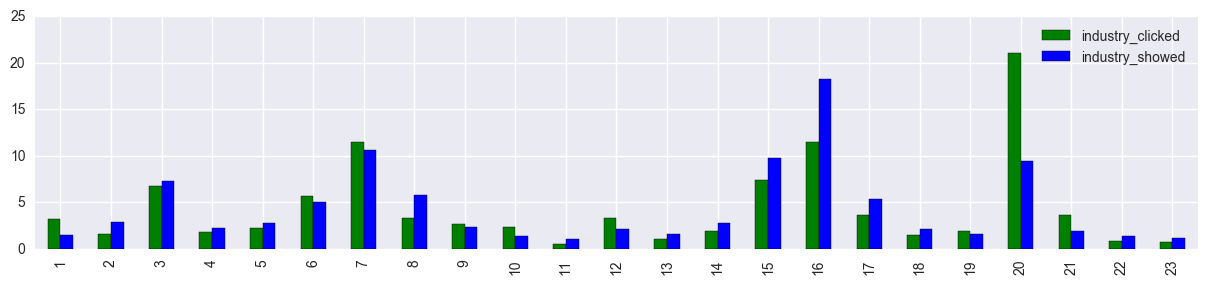

In [50]:
industry_showed = users_not_interested[users_not_interested.industry_id!=0].industry_id.value_counts()/len(users_not_interested[users_not_interested.industry_id!=0])*100
industry_clicked = users_interested[users_interested.industry_id!=0].industry_id.value_counts()/len(users_interested[users_interested.industry_id!=0])*100
df = pd.DataFrame({'industry_showed':industry_showed, 'industry_clicked':industry_clicked})
df.plot(kind='bar', figsize=(15, 3), color=['green', 'blue']);

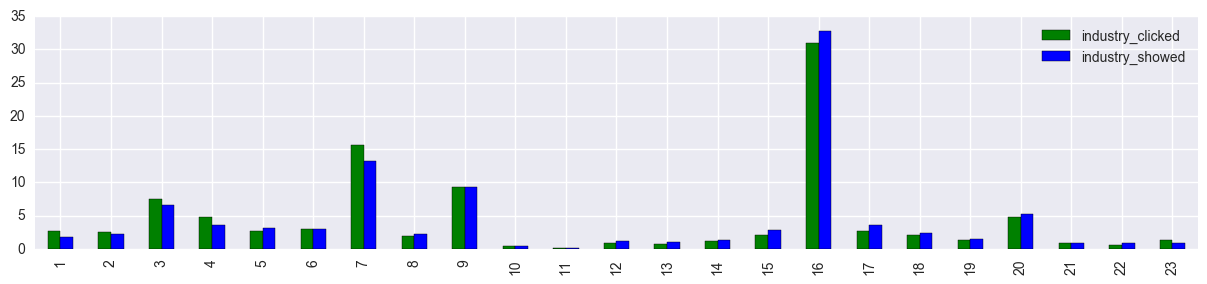

In [51]:
industry_showed = items_not_interesting[items_not_interesting.industry_id!=0].industry_id.value_counts()/len(items_not_interesting[items_not_interesting.industry_id!=0])*100
industry_clicked = items_interesting[items_interesting.industry_id!=0].industry_id.value_counts()/len(items_interesting[items_interesting.industry_id!=0])*100
df = pd.DataFrame({'industry_showed':industry_showed, 'industry_clicked':industry_clicked})
df.plot(kind='bar', figsize=(15, 3), color=['green', 'blue']);

Conclusions: 

    1. Industry_id match does not seem very relevant, however it is more relevant when showing than when clicking
    2. Users from industries 20 click more

## experience_n_entries_class

In [52]:
data_showed.experience_n_entries_class.value_counts()/float(len(data_showed))*100

3    61.808035
2    22.380701
1    15.811264
Name: experience_n_entries_class, dtype: float64

In [53]:
data_clicked.experience_n_entries_class.value_counts()/float(len(data_clicked))*100

3    49.697780
1    27.228017
2    23.074203
Name: experience_n_entries_class, dtype: float64

Conclusions: 

    From the showed interactions, 60% of them corresponded to users with more than 5 entries in CV (level=3). However, from the clicked interactions, only 50% corresponded to them. It seems like people with a lot of job experiences is not so interested in changing jobs. 

## experience_years_experience & experience_years_in_current

In [54]:
data_showed.experience_years_experience.value_counts()/float(len(data_showed))*100

5    22.588777
4    21.826189
7    20.124703
6    17.142283
0     9.019593
3     4.821791
2     3.360383
1     1.116281
Name: experience_years_experience, dtype: float64

In [55]:
data_clicked.experience_years_experience.value_counts()/float(len(data_clicked))*100

4    20.434967
7    19.872835
5    19.697442
6    16.414436
0    15.691809
3     4.704424
2     2.547667
1     0.636420
Name: experience_years_experience, dtype: float64

Conclusion:
1. Very similar behaviour in both groups

In [56]:
data_showed.experience_years_in_current.value_counts()/float(len(data_showed))*100

2    30.715750
1    22.403781
4    14.290133
3    12.924494
0    10.783657
5     4.676412
6     2.544616
7     1.661156
Name: experience_years_in_current, dtype: float64

In [57]:
data_clicked.experience_years_in_current.value_counts()/float(len(data_clicked))*100

2    28.406705
0    17.443156
1    16.040013
4    14.738172
3    14.167698
5     4.828173
6     2.663669
7     1.712415
Name: experience_years_in_current, dtype: float64

Conclusion:
    1. Very similar behaviour

## edu_degree

In [58]:
data_showed.edu_degree.value_counts()/float(len(data_showed))*100

0    54.475415
2    27.552736
1    13.104613
3     4.867237
Name: edu_degree, dtype: float64

In [59]:
data_clicked.edu_degree.value_counts()/float(len(data_clicked))*100

0    63.989623
2    21.865323
1    10.488021
3     3.657032
Name: edu_degree, dtype: float64

Conclusion:
    1. Majority of users in both groups have not specifed the edu_degree 

## field of studies

In [67]:
# Count how many times each field of study appears
field_of_studies_showed = data_showed.edu_fieldofstudies.apply(lambda x: list(x))
field_of_studies_clicked = data_clicked.edu_fieldofstudies.apply(lambda x: list(x))

In [68]:
import itertools
field_of_studies_showed = list(itertools.chain.from_iterable(field_of_studies_showed.values.flatten()))
field_of_studies_clicked = list(itertools.chain.from_iterable(field_of_studies_clicked.values.flatten()))

In [69]:
from collections import Counter
{k: v/float(len(field_of_studies_showed))*100 for k, v in dict(Counter(field_of_studies_showed)).items()}

{'0': 38.25315701907818,
 '1': 0.21386516463028754,
 '2': 5.9112801068045195,
 '3': 11.563339412767238,
 '4': 1.6299214867257394,
 '5': 11.010427527562888,
 '6': 0.6891922321269446,
 '7': 5.696347750733961,
 '8': 24.01319475496751,
 '9': 1.0192745446027325}

In [70]:
{k: v/float(len(field_of_studies_clicked))*100 for k, v in dict(Counter(field_of_studies_replied)).items()}

{'0': 46.52840166239382,
 '1': 0.36337474709848006,
 '2': 4.28654381313408,
 '3': 14.633411486294015,
 '4': 1.5636070147760224,
 '5': 8.640101964049638,
 '6': 0.7167064735485096,
 '7': 4.156897546581355,
 '8': 18.22863027806385,
 '9': 0.882325014060229}

Conclusions: 
    1. the distribution of field of studies is very similar between the two groups

## WTCJ

In [71]:
data_showed.wtcj.value_counts()/len(data_showed)*100

1    75.154986
0    24.845014
Name: wtcj, dtype: float64

In [72]:
data_clicked.wtcj.value_counts()/len(data_clicked)*100

1    81.70451
0    18.29549
Name: wtcj, dtype: float64

Conclusion:
    1. There is not a lot of difference between both groups, however there is slghtly more willingness to change jobs among the users who have clicked, compared to the ones who were only showed

## premium

In [73]:
data_showed.premium.value_counts()/len(data_showed)*100

0    64.483397
1    35.516603
Name: premium, dtype: float64

In [74]:
data_clicked.premium.value_counts()/len(data_clicked)*100

0    78.553594
1    21.446406
Name: premium, dtype: float64

Conclusion:
1. Not much difference, but it seems that users who click normally are not premium, and more job postings are showed to premium

## employment

In [75]:
data_showed.employment.value_counts()/float(len(data_showed))*100

1    96.511369
2     2.066958
3     1.243577
4     0.158228
0     0.019868
Name: employment, dtype: float64

In [76]:
data_clicked.employment.value_counts()/float(len(data_clicked))*100

1    92.802930
2     4.967216
3     1.552118
4     0.651516
0     0.026220
Name: employment, dtype: float64

Conclusions: 
    1. Both groups have majority of jobs full time

## title & tag

In [77]:
data_showed.title.head()

0    {4099592, 310589, 3842576, 2629116}
1    {4099592, 310589, 3842576, 2629116}
2                              {2087584}
3                              {2087584}
4                              {2087584}
Name: title, dtype: object

In [78]:
data_clicked.tags.head()

0                           {1627300, 540282, 3418248}
1    {1868189, 3858649, 1760579, 4313058, 3502994, ...
2                                                  {0}
3                                                  {0}
4                                                  {0}
Name: tags, dtype: object

In [79]:
def intersect(x):
    return x[0]&x[1]

Find the intersection between titles and tags

In [80]:
data_showed['title_tag_match'] = data_showed[['title', 'tags']].apply(intersect, axis=1)
data_clicked['title_tag_match'] = data_clicked[['title', 'tags']].apply(intersect, axis=1)

In [81]:
# Count how many titles
data_showed['num_titles'] = data_showed.title.apply(len)
data_showed.num_titles.value_counts()/float(len(data_showed))*100

1     21.830353
2     20.688137
3     17.553319
4     12.411859
5      9.771592
6      6.710296
7      4.368046
8      2.726995
9      1.562294
10     0.946394
11     0.606858
12     0.214500
14     0.186899
13     0.186424
15     0.185353
16     0.022604
17     0.013681
18     0.012611
19     0.001071
22     0.000714
Name: num_titles, dtype: float64

In [82]:
# Count how many titles
data_clicked['num_titles'] = data_clicked.title.apply(len)
data_clicked.num_titles.value_counts()/float(len(data_clicked))*100

1     37.034528
2     19.426904
3     16.486341
4      9.027672
5      6.494306
6      4.227705
7      3.215471
8      2.076907
9      0.829094
10     0.463609
11     0.306292
12     0.154139
15     0.099912
13     0.065549
14     0.050453
16     0.019863
18     0.010130
17     0.008343
20     0.001192
19     0.001192
22     0.000397
Name: num_titles, dtype: float64

Conclusions:

1. More people with just one title seem to click compared to the ones who are only showed

## is_payed

In [83]:
data_showed.is_payed.value_counts()/float(len(data_showed))*100

1    71.503607
0    28.496393
Name: is_payed, dtype: float64

In [84]:
data_clicked.is_payed.value_counts()/float(len(data_clicked))*100

1    54.275873
0    45.724127
Name: is_payed, dtype: float64

# Conclusions:
    1. It seems that for showed interactions, 71 % of the posted jobs were payed for, however, when the user clicked to the posting only 54% of them were payed for.

## Geography

In [85]:
n = float(len(data_clicked))
print np.sum(data_clicked.country_item==data_clicked.country_user)/n*100.0

83.8614653952


In [86]:
n = float(len(data_showed))
print np.sum(data_showed.country_item==data_showed.country_user)/n*100.0

88.1859572023


In [87]:
n = float(len(data_clicked))
print np.sum(data_clicked.region_item==data_clicked.region_user)/n*100.0

34.1207807866


In [88]:
n = float(len(data_showed))
print np.sum(data_showed.region_item==data_showed.region_user)/n*100.0

28.2506046571


# Conclusions

I still need to think but some of the conclusions I have extracted here I believe can be converted into features for our classification problem. I will revise this later

# Possible extra features:

- career level match
- career level item < career level user
- industry match
- user industry is 3
- region and country match